# Cheng Hsuan Chiang 
# ID: 12283758
# Homework5: FX Carry Strategy

## University of Chicago - Financial Mathematics
## FINM 33150 - Regression Analysis and Quantitative Trading Strategies

### Period: January 2015 - Mar 2022

# 0. Introduction

**The carry strategy is borrowing at low interest rates and lending at high interest rates. This is often done by borrowing in a low-yield currency like GBP, converting to foreign currency, and lending at higher interest rates in the forein currency. Here we will execute the trade using cross-currency swaps.**

**Here we analyze four different carry trade strategies involving cross-currency fixed-float and basis swaps. In each we borrow UK British Pound at 1M(0.08Y) overnight index swaps(OIS) + 50 bps and use 80% leverage to purchase 5-year government bonds in one of the following markets:**

* South Africa Rand(ZAR)
* Thai Baht(THB)
* Pakistani Rupee(PAK)
* Philippine Peso(PHP)

Our investment period spans from 2015-01-01 to 2020-04-01. We mark to market back to USD on a weekly basis.

## 0.1 Implementation Details

* Yield curves are from [Quandl Global Yield Curves (YC)](https://www.quandl.com/data/YC-Global-Yield-Curves)
* Foreign exchange rates are from [Quandl Foreign Exchange Rates (CUR)](https://www.quandl.com/data/CUR-Foreign-Exchange-Rates)
* 1-Month(0.08Y) UK overnight index swaps(OIS) is from [United Kingdom Overnight Index Swaps - Spot Curve](https://data.nasdaq.com/data/YC/GBR_ISSC-united-kingdom-overnight-index-swaps-spot-curve)
* Weekly returns are calculated as follows:
    * Exchange \$2.0 million USD capital for GBP
    * Borrow \$8.0 million USD value GBP at 1-Month(0.08Y) UK overnight index swaps(OIS) +50bps (borrow market)
    * Convert \$10.0 million USD value GBP to currency of market in which bond will be purchased (lend market)
    * Calculate zero coupon bond curve from swap rate yield curve in lend market
    * Calculate notional amount of \$10.0 million USD value bonds purchased using zero coupon bond curve
    * Calculate zero coupon bond curve from swap rate yield curve in lend market one week later
    * Calculate current value of notional amount of purchased bonds from updated zero coupon bond curve with rates interpolated back one week to align with cash flow of purchased bond
    * Repay borrowings
    * Convert capital and profit back to USD
    * Calculate return

# 1. Download data

**First we retrieve all necessary packages, imports and Functions:**

In [1]:
%matplotlib inline
import datetime
import functools
import matplotlib.pyplot as plt
import matplotlib as mpl
from   matplotlib                import pyplot as plt
from   urllib.request            import urlretrieve
import pandas                    as     pd
import numpy                     as     np
import seaborn                   as     sns
import statsmodels.api           as     sm
from scipy.stats import norm
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import quandl
import scipy
import sys
import requests
import time
import warnings
import pandas_datareader.data as web
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning) 
pd.set_option("display.precision", 4)
pd.options.display.max_rows = None
pd.set_option('display.float_format',lambda x : '%.6f' %x)
quandl.ApiConfig.api_key = "CPkrEDEshfeXucLHHk_T"

In [2]:
def performanceMetrics(returns, annualization = 1):
    metrics                                = pd.DataFrame(index=returns.columns)
    metrics['Number of Weeks']             = returns.count() 
    metrics['Mean']                        = returns.mean() * annualization
    metrics['Vol']                         = returns.std() * np.sqrt(annualization)
    metrics['Sharpe']                      = (returns.mean() / returns.std()) * np.sqrt(annualization)
    metrics['Sortino']                     = (returns.mean() / returns[returns < 0].std()) * np.sqrt(annualization)
    metrics['Min']                         = returns.min()
    metrics['Max']                         = returns.max()
    metrics['25% Quantile']                = returns.quantile(0.25)
    metrics['75% Quantile']                = returns.quantile(0.75)
    metrics['Skewness']                    = returns.skew()
    metrics['Excess Kurtosis']             = returns.kurtosis()
    metrics['VaR (Quantile {})'.format(0.05)] = returns.quantile(0.05)   
    
    metrics.sort_values('Sharpe',ascending = False)
    return metrics

In [3]:
def tail_risk_report(data, q=0.05, returns=True):
    df                                           = data.copy()
    df.index                                     = data.index.date
    report                                       = pd.DataFrame(columns = df.columns)
    
    #report.loc['Skewness']                       = df.skew()
    #report.loc['Excess Kurtosis']                = df.kurtosis()
    #report.loc['VaR (Quantile {})'.format(q)]    = df.quantile(q)
    #report.loc['VaR (Normal)']                   = df.mean() + scipy.stats.norm().ppf(q) * df.std()
    report.loc['Expected Shortfall']             = df[df < df.quantile(q)].mean()
    report.loc['Expected Shortfall (Normal)']    = df.mean() - scipy.stats.norm.pdf((scipy.stats.norm().ppf(q)))/q * df.std()
    
    if returns == True:
        cum_ret                                  = (1 + df).cumprod()
        rolling_max                              = cum_ret.cummax()
        drawdown                                 = (cum_ret - rolling_max) / rolling_max
    else:
        cum_ret                                  = df.cumsum()
        rolling_max                              = cum_ret.cummax()
        drawdown                                 = (cum_ret - rolling_max)
         
    report.loc['Max Drawdown']                   = drawdown.min()
    report.loc['MDD Start']                      = None
    report.loc['MDD End']                        = drawdown.idxmin()
    report.loc['Recovery Date']                  = None
    report.loc['Single Largest Drawdown']        = df.min()
    report.loc['Single Largest Drawdown Date']   = df.idxmin()
    
    for col in df.columns:
        report.loc['MDD Start', col]             = (rolling_max.loc[:report.loc['MDD End', col]])[col].idxmax()
        recovery_df                              = (drawdown.loc[report.loc['MDD End', col]:])[col]
        # modify the threshold for recovery from 0 to 0.001
        try:
            report.loc['Recovery Date', col]     = recovery_df[recovery_df >= 0].index[0]
            report.loc['Recovery period (days)'] = (report.loc['Recovery Date'] - report.loc['MDD Start']).dt.days

        except:
            report.loc['Recovery Date', col]     = None
            report.loc['Recovery period (days)'] = None
    return round(report,4)

In [4]:
start_date,end_date="2015-01-01","2022-02-10"

In [5]:
def fetch_quandl(my_securities,start_date,end_date):
    qdata = quandl.get(list(my_securities), returns="pandas",authtoken="CPkrEDEshfeXucLHHk_T",start_date=start_date, end_date=end_date)
    return qdata

## 1.1 We are plotting the 5Y curves for various countries

**This helps us visualize the difference in rates, for a carry trade we borrow in a currency with low interest rates and lend in a currency with higher interest rate.<br>
We will implement the carry trade trading strategy based on a difference of at least 50bps to trade.**

In [6]:
data=fetch_quandl(("YC/ZAF5TO10Y","YC/THA5Y","YC/PAK5Y","YC/PHL5Y","YC/GBR5Y","YC/USA5Y"),start_date,end_date)/100
data.to_excel("Quandl_data.xlsx")
data=data.interpolate(axis = 0, method = 'index')

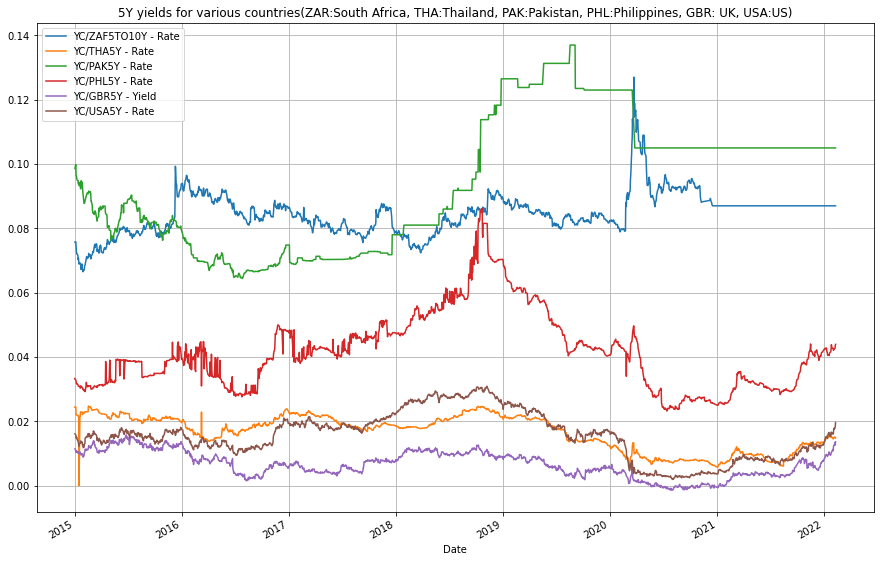

In [7]:
data.plot(figsize =(15,10))
plt.legend(loc='upper left')
plt.title("5Y yields for various countries(ZAR:South Africa, THA:Thailand, PAK:Pakistan, PHL:Philippines, GBR: UK, USA:US)")
plt.grid(True)
plt.show()

In [8]:
fx=fetch_quandl(("CUR/ZAR",),start_date,end_date)
fx.to_excel("CUR_ZAR.xlsx")
lendz=fetch_quandl(("YC/ZAF",),start_date,end_date)/100
lendz.to_excel("YC_ZAF.xlsx")

fx=fetch_quandl(("CUR/THB",),start_date,end_date)
fx.to_excel("CUR_THB.xlsx")
lend=fetch_quandl(("YC/THA",),start_date,end_date)/100
lend.to_excel("YC_THA.xlsx")

fx=fetch_quandl(("CUR/PKR",),start_date,end_date)
fx.to_excel("CUR_PKR.xlsx")
lend=fetch_quandl(("YC/PAK",),start_date,end_date)/100
lend.to_excel("YC_PAK.xlsx")

fx=fetch_quandl(("CUR/PHP",),start_date,end_date)
fx.to_excel("CUR_PHP.xlsx")
lend=fetch_quandl(("YC/PHL",),start_date,end_date)/100
lend.to_excel("YC_PHL.xlsx")

fx=fetch_quandl(("CUR/GBP",),start_date,end_date)
fx.to_excel("CUR_GBP.xlsx")

ukois=fetch_quandl(("YC/GBR_ISSC",),start_date,end_date)/100    
ukois.to_excel("YC_GBR_ISSC.xlsx")

borrow=fetch_quandl(("YC/GBR5Y",),start_date,end_date)/100    
borrow.to_excel("YC_GBR5Y.xlsx")


In [9]:
def extract_data(currency):
    if currency =="ZAR":
        start_date,end_date="2015-01-01","2020-04-01"
        fx=fetch_quandl(("CUR/ZAR",),start_date,end_date)
        lend=fetch_quandl(("YC/ZAF",),start_date,end_date)/100
        fx=fx.interpolate(axis=0,methd='index').resample("W-WED").last()
        lend=lend.interpolate(axis=0, method='index').iloc[:,:3].resample("W-WED").last().fillna(method="ffill")
        lend.columns=[3,5,10]
    if currency =="THB":
        start_date,end_date="2015-01-01","2020-04-01"
        fx=fetch_quandl(("CUR/THB",),start_date,end_date)
        lend=fetch_quandl(("YC/THA",),start_date,end_date)/100
        fx=fx.interpolate(axis=0,methd='index').resample("W-WED").last()
        lend=lend.interpolate(axis=0, method='index').iloc[:,:7].resample("W-WED").last().fillna(method="ffill")
        lend.columns=[1/12,1/4,1/2,1,2,3,5]
    if currency =="PKR":
        start_date,end_date="2015-01-01","2020-04-01"
        fx=fetch_quandl(("CUR/PKR",),start_date,end_date)
        lend=fetch_quandl(("YC/PAK",),start_date,end_date)/100
        fx=fx.interpolate(axis=0,methd='index').resample("W-WED").last()
        lend=lend.interpolate(axis=0, method='index').iloc[:,:4].resample("W-WED").last().fillna(method="ffill")
        lend.columns=[1,2,3,5]
    if currency =="PHP":
        start_date,end_date="2015-01-01","2020-04-01"
        fx=fetch_quandl(("CUR/PHP",),start_date,end_date)
        lend=fetch_quandl(("YC/PAK",),start_date,end_date)/100
        fx=fx.interpolate(axis=0,methd='index').resample("W-WED").last()
        lend=lend.interpolate(axis=0, method='index').iloc[:,:4].resample("W-WED").last().fillna(method="ffill")
        lend.columns=[1,2,3,5]
    
    borrow=fetch_quandl(('YC/GBR5Y',),start_date,end_date)/100
    borrow=borrow.interpolate(axis=0,method='index').iloc[:,:1].resample("W-WED").last().fillna(method="ffill")
    borrow.columns=[5]
    
    ukois=fetch_quandl(('YC/GBR_ISSC',),start_date,end_date)/100
    ukois=ukois.interpolate(axis=0,method='index').iloc[:,:1].resample("W-WED").last().fillna(method="ffill")
    ukois.columns=[0.08]
    
    gbpfx=fetch_quandl(("CUR/GBP",),start_date,end_date)
    gbpfx=gbpfx.interpolate(axis=0,method='index').resample("W-WED").last()
    
    return fx, lend, borrow, ukois, gbpfx

# 2. Convert Spot Curve into Zero-Coupon-Bond Curve and compute Bond Prices

In [10]:
def bond_price(zcb, coupon_rate, tenor):
    times = np.arange(tenor,0, step=-0.5)[::-1]
    if times.shape[0]==0:
        p = 1.0
    else:
        r = np.interp(times, zcb.index.values, zcb.values[:,0]) # Linear interpolation
        p = np.exp(-tenor*r[-1]) + 0.5 * coupon_rate * np.exp(-r*times).sum()
    return p

In [11]:
def compute_zcb_curve(spot_rates_curve):
    zcb_rates = spot_rates_curve.copy()
    for curve in spot_rates_curve.columns:
        spot = spot_rates_curve[curve]
        for tenor, spot_rate in spot.iteritems():            
            if tenor>0.001:
                times = np.arange(tenor-0.25, 0, step=-0.25)[::-1]
                coupon_quarter = 0.25*spot_rate
                z = np.interp(times, zcb_rates[curve].index.values, zcb_rates[curve].values) # Linear interpolation
                preceding_coupons_val = (coupon_quarter*np.exp(-z*times)).sum()
                zcb_rates[curve][tenor] = -np.log((1-preceding_coupons_val)/(1+coupon_quarter))/tenor
    return zcb_rates

# 3. FX Carry Trade implementation

## 3.1. Signals generation

We are using **5Y swap rates** for generation of trading signals:

$$ Y_llending(5y) - Y_bborrowing(5y) > 50 bps \Rightarrow \text{ borrow in } j \text{, lend in } i $$


$$ Y_llending(5y) - Y_bborrowing(5y) < 50 bps \Rightarrow \text{ no signal } $$


As we can see from the ***first plot "5Y yields for various countries"***, we will use UK 1M(0.08Y) rates for overnight index swap(OIS) as the currencies in currency pair, it will be a **borrowing currency**.At the same time **ZAR** **PAK** has the highest yield, and it will be a **lending currency**.

- Capital owned = $2,000,000

- Capital borrowed = $8,000,000

- Capital invested = $10,000,000

If borrowing currency is **b** and lending currency is **l** $\Rightarrow$ 

1) **at time $t_0$**, i.e. Wednesday of week $t_0$:

- borrow equivalent of \$8,000,000 in **b**, i.e. borrow $ \$8,000,000 \cdot FX^b_0 $ of **b-currency**


- buy equivalent of \$10,000,000 of **l-currency** T-year bonds, i.e. buy $ \frac{\$10,000,000 \cdot FX^l_0}{ B_0^l} $number of bonds 

2) **at time $t_1$**, i.e. Wednesday of week $t_1$, where $t_1 - t_0 = $ 1 week:

- return borrowed amount with interest, i.e. return $\frac{ \$8,000,000 \cdot FX^b_0  \cdot ( 1 + UKOIS1M_0^b + 50bp)}{FX^b_1}$ (in USD equivalent)


- sell $ \frac{\$10,000,000 * FX^l_0}{ B_0^l} $ number of bonds for $B_1^l \Rightarrow$ get $ \frac{\$10,000,000 \cdot FX^l_0 \cdot B_1^l}{ B_0^l \cdot FX^l_1} $ in USD


**Performance of FX Carry strategy** will be assessed based on:
- **Cumulative PnL**;

- **Sharpe Ratio** = $ \frac{E(r - r_f)}{\sqrt{E[(r-r_b)^2]}} $;

- **Sortino Ratio** = $ \frac{E(r - r_b)}{\sqrt{E[ (r-r_b)^2 | r < r_b ]}} $

In [12]:
def carry_trade(cur,perform="No",tail="No",hist="No",weeklyreturn="No",cumulativepnl="No",fxmovement="No",yieldcurve="No",ratio="No",vix="No",graph=True):
    
    fx ,df_lend ,df_borrow ,ukois ,gbpfx  = extract_data(cur)
    
    self_capital           = 2000000
    borrowed_capital       = 8000000
    total_capital          = self_capital + borrowed_capital
    
    zero_curve=compute_zcb_curve(df_lend.T)
    df=df_borrow[[]]
    df["full_bond_price"]=0.0
    df["1w_bond_price"]=0.0    
    for i in range(0,len(zero_curve.T)):
        df.iat[i,0]=bond_price(zero_curve.iloc[:,i:i+1],df_lend.iloc[i:i+1,:][5],5.)
        if not i==len(zero_curve.T)-1:
            df.iat[i+1,1]=bond_price(zero_curve.iloc[:,i+1:i+2],df_lend.iloc[i:i+1,:][5],5.-1/52)
    
    df['borrow_5y']  = df_borrow[5]       
    df['lend_5y']    = df_lend[5]
    df['borrow_ois'] = ukois
    df['fx']         = fx
    df['gbpfx']      = gbpfx
     
    df['local_currency']     = total_capital * df['fx']
    df['bond_bought']        = (df['local_currency']/df["full_bond_price"]).fillna(0.)
    df['bond_bought'][-1]    = 0.
    df['bond_bought']        = np.where(df['lend_5y']-df['borrow_5y']>0.005,df['bond_bought'],0.)
    df['local_recv_1w']      = (df['bond_bought'].shift(1) * df['1w_bond_price']).fillna(0.)
    df['USD_recv']           = df['local_recv_1w'] / df['fx']    
    df['Bond_Pnl']           = df['USD_recv'] - np.where(df['bond_bought'].shift(1)>0.,total_capital,0.)
    df['Bond_Pnl'][0]        = 0.
    df['borrow_interest']    = -1 *np.where(df['bond_bought'].shift(1)>0.,borrowed_capital,0.) *((df['borrow_ois'].shift(1).fillna(0)+0.005)/52)
    df['borrow_interest'][0] = 0.
    df['Pnl']= df['Bond_Pnl'] + df['borrow_interest']
    
    #return metrics
    df['Return'] = df['Pnl'] / self_capital
    df['Return_cum'] = df['Return'].cumsum()
    df['running_sharpe'] = df['Return'].rolling(52).mean()/df['Return'].rolling(52).std()
    df['running_sortino'] = df['Return'].rolling(52).mean()/df['Return'].rolling(52).apply(lambda x: np.std([i for i in x if i < 0],ddof=1))
    
    #columns to calculate the breakdown of pnl
    df['fx_held_const']=df['fx'].shift(1).fillna(0)
    df['USD_recv_no_fx_change']=df['local_recv_1w'] / df['fx_held_const']
    df['Bond_Pnl_no_fx_change'] = df['USD_recv_no_fx_change'] - np.where(df['bond_bought'].shift(1)>0.,total_capital,0.)
    df['Bond_Pnl_no_fx_change'][0]=0.
    df['fx_pnl']= df['Bond_Pnl'] - df['Bond_Pnl_no_fx_change']      
    
    df['Cumulative_Pnl']=df['Pnl'].cumsum()
    df['Cumulative_fx_pnl']=df['fx_pnl'].cumsum()
    df['Cumulative_bond_pnl']=df['Bond_Pnl_no_fx_change'].cumsum()
    df['Cumulative_borrow_interest']=df['borrow_interest'].cumsum()
       #calling the graphing function 
    if graph == True:
        graph_metrics(df,cur,hist,weeklyreturn,cumulativepnl,fxmovement,yieldcurve,ratio,vix)
    if(perform=="Yes"):
        performanceMetrics(df[['Return']], annualization = 1)
    
    if(tail=="Yes"):
        tail_risk_report(df[['Return']], q=0.05, returns=True)
    
    return df, performanceMetrics(df[['Return']], annualization = 1), tail_risk_report(df[['Return']], q=0.05, returns=True)

In [13]:
def graph_metrics(df1,cur,hist,weeklyreturn,cumulativepnl,fxmovement,yieldcurve,ratio,vix):
    df=df1.copy()

    if(hist=="Yes"):
        plt.figure(figsize=(30,5))
        #plt.subplots(figsize=(5,5))
        plt.subplot(121)
        plt.title("Distribution of %s/USD pair weekly returns"%cur)
        plt.hist(df['Return'],bins=40)
        plt.grid(linestyle='--')
        plt.xlabel("Weekly Return")
        plt.ylabel("Number of Weeks")
    elif(weeklyreturn=="Yes"):
        plt.subplots(figsize=(30,5))
        plt.subplot(122)
        plt.plot(df.index,df['Return'],label='Weekly Return',c='forestgreen')
        plt.grid(True)
        plt.title("Weekly return for Carry Trade %s/USD pair"%cur)
        plt.xlabel("Time")
        plt.ylabel("Weekly Return")
        plt.show()
        plt.close()
    elif(cumulativepnl=="Yes"):
        plt.figure(figsize=(15,35))
        plt.subplots(figsize=(15,15))
        plt.subplot(311)
        plt.plot(df.index,df['Pnl'].cumsum()/np.power(10.,6),label="%s/USD pair Cummulative $ Profit and Loss"%cur,c='mediumblue')
        plt.plot(df.index,df['fx_pnl'].cumsum()/np.power(10.,6),label="FX Profit and Loss",linestyle="--",c='maroon')
        plt.plot(df.index,df['Bond_Pnl_no_fx_change'].cumsum()/np.power(10.,6),label="Bond Profit and Loss",linestyle="--")
        plt.plot(df.index,df['borrow_interest'].cumsum()/np.power(10.,6),label="Interest of OIS+50bp",linestyle="--")
        plt.title("Breakdown of %s/USD pair Cummulative $%.2f M Profit and Loss"%(cur,(df['Pnl'].cumsum()[-1]/pow(10.,6))))
        plt.xlabel("Time")
        plt.ylabel("$ Profit and Loss")
        plt.grid(True)
        plt.legend()
        plt.show()
    elif(fxmovement=="Yes"):
        fig, ax1 = plt.subplots(figsize=(15,10))
        plt.title("FX rate movement")
        ax1.set_xlabel("Time")
        ax1.set_ylabel("USD/%s FX Rate(green)"%cur)
        plt.plot(df.index,df["fx"],label='USD/%s'%cur,c='g')
        ax2 = ax1.twinx()
        ax2.set_ylabel('USD/GBP FX Rate(blue)')
        plt.plot(df.index,df['gbpfx'],c='b',label="USD/GBP FX Rate(blue)") 
        plt.grid(True)
        #plt.legend()
        plt.show()
    elif(yieldcurve=="Yes"):
        plt.subplots(figsize=(15,10))
        plt.subplot(313)
        plt.plot(df.index,df["borrow_5y"]+0.005,label='UK 5Y + 50bps',linestyle="-")
        plt.title("5Y Yields/UK OIS 1M(0.08Y) Curves")
        plt.plot(df.index,df["lend_5y"]-df["borrow_5y"],label="5Y Spread between {} and GBP".format(cur))
        plt.plot(df.index,df["lend_5y"],label='%s 5Y'%cur,linestyle="-")
        plt.plot(df.index,df['borrow_ois']+0.005,label='UK OIS 1M(0.08Y) + 50bps')
        plt.xlabel("Time")
        plt.ylabel("Interest Rates")
        plt.grid(True)
        plt.legend()
        plt.show()
        plt.close()
    elif(ratio=="Yes"):
        plt.figure(figsize=(15,5))
        plt.title("Sharpe Ratio and Sortino Ratio")
        plt.plot(df.index,df['running_sharpe'],label="Sharpe Ratio",c='mediumblue')
        plt.plot(df.index,df['running_sortino'],label="Sortino Ratio",c='forestgreen')
        plt.xlabel("Time")
        plt.ylabel("Ratios(Sharpe/Sortino)")
        plt.grid(True)
        plt.legend()
        plt.show()
    elif(vix=="Yes"):
        sdate,edate="2015-01-01","2020-04-01"
        vix = web.DataReader('^VIX', 'yahoo', start=sdate, end=edate)
        vix = vix.resample('W-WED').last().fillna(method="ffill")["Adj Close"]
        spx = web.DataReader('^GSPC', 'yahoo',start=sdate, end=edate)
        spx = spx.resample('W-WED').last().fillna(method="ffill")["Adj Close"]
        spx_arr = spx/spx[0]-1
        fig, ax = plt.subplots(figsize=(15,4))
        ax2 = ax.twinx()
        ax.plot(df.index,df['Return'].cumsum(),label="Cummulative weekly Return",color='mediumblue')
        #calculating cummulative spx return similar to return above (simple addition instead of product)
        ax.plot(spx_arr,label="SPX Return",linestyle="-",color='forestgreen')
    
        ax.set_ylabel("Weekly Return")
        ax2.plot(df.index,vix,label="VIX",linestyle="-",color='maroon')
        ax2.set_ylabel("VIX Level")
        plt.title("Cummulative %s carry trade weekly Return with VIX and SPX"%cur)
        plt.xlabel("Time")
        ax2.legend(loc="upper right")
        ax.legend(loc="upper left")
        plt.grid(True)
        plt.show()

# 4.1 ZAR Carry Trade(South Africa)

## 4.1.1 Return Analysis

**1.1 Return Distribution : We can see a high value of distribution around 0, the left tail is fatter than the one on the right, the median is <0 (a little more distribution to the left than right). Return Kurtosis is 0.46.**

* This doesn't appear to be a great strategy with a mean weekly return of -0.0001 (-0.0052 annualized), standard deviation of 0.1113 and Sharpe ratio of -0.000895.
* The distribution of returns is consistent with that of a carry trade strategy, with some fatness in the tails (excess kurtosis of 0.43) and some negative skewness (-0.229).

**1.2 Weekly Return: We can see when emerging market fx performed worst in 2015 August(RMB devaluated in August), 2016 January(when wti oil price drop to around 20 dollars a barrel), 2018(when Euro started to weaken from April and emerging market fx plummeting including Turkish Lira, India Rupee, Indonesia Rupiah) and 2020(when risk sentiment turned, emerging market risk asset plummeting). So the most important thing for carry trade is Emerging Market risk sentiment and some of the important indicators including Euro(US and non-US GDP growth difference), difference between interest rate market and risk sentiment for risk assets.**

* It started out losing money in 2015 and started to  enjoys a relatively long run of positive performance from 2016/1 to 2018/3, which is global recovery period. However, when Euro and EM currencies started to weaken from 2018/4, ZAR carry trade strategy started to lose money from 2018/4 to 2020/4.

**1.3 Cumulative Profit and Loss(Drivers of profit and loss): The total profit and loss is about -54,578. The profit from bond profit and loss is about 3,982,293. However the loss from fx is about -3,629,131 and we also have to count borrowing cost for about 407,740.** 

* As noted above, returns come primarily from two source: (i) changes in the value of the bond in the lend market resulting from changes in the yield curve there and (ii) foreign exchange movements.
* Profits result from decreases in rates in the lending market, driving up the price of the bond that we own.
* To be able to discern the impact on those effects separately, the components chart below shows the lend-borrow fx rate and the borrow-home fx rates separately.

*2015Q1-Q4*

* For the initial period of negative perfomance, negative peformance driven by significant unfavorable movements of ZAR fx rates.

*2016Q1-2018Q1*

* Relatively consistent positive perormance - exhibiting "normal" carry trade behavior - driven by, on average, declines in lend market yields and positive lend-borrw fx rate changes.

* This is actually quite a run, with nearly a 1.5x return on investment. If we were to look just at this period, this would look like a very attractive strategy.

*2018Q1 - 2020Q1*
* The ZAR fx exchange rate moved in the wrong direction - there were several days with nearly 4% unfavorable changes during the same time frame.

In [14]:
df_zar, results_zar, tail_zar =carry_trade("ZAR",perform="Yes",tail="No",hist="No",weeklyreturn="No",cumulativepnl="No",fxmovement="No",yieldcurve="No",ratio="No",vix="No",graph=False)
results_zar

,Number of Weeks,Mean,Vol,Sharpe,Sortino,Min,Max,25% Quantile,75% Quantile,Skewness,Excess Kurtosis,VaR (Quantile 0.05)
Return,274,-0.000100,0.111316,-0.000895,-0.001385,-0.381778,0.317537,-0.071608,0.077975,-0.229759,0.462551,-0.180026


In [15]:
df_zar, results_zar, tail_zar =carry_trade("ZAR",perform="No",tail="Yes",hist="No",weeklyreturn="No",cumulativepnl="No",fxmovement="No",yieldcurve="No",ratio="No",vix="No",graph=False)
tail_zar.T 

,Expected Shortfall,Expected Shortfall (Normal),Max Drawdown,MDD Start,MDD End,Recovery Date,Single Largest Drawdown,Single Largest Drawdown Date,Recovery period (days)
Return,-0.245674,-0.229713,-0.881600,2015-02-04,2016-01-20,None,-0.381778,2018-08-15,NaN


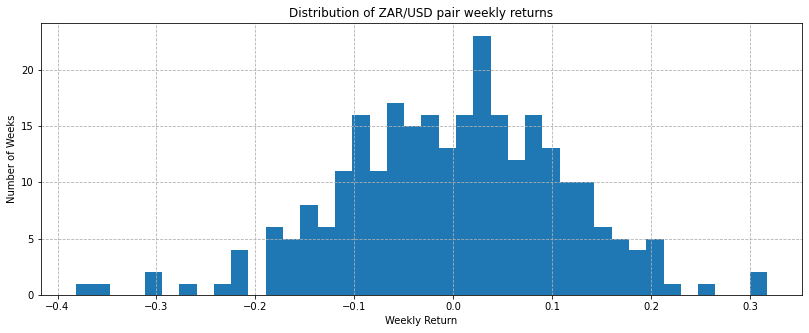

In [16]:
df=carry_trade("ZAR",perform="No",hist="Yes",weeklyreturn="No",cumulativepnl="No",fxmovement="No",yieldcurve="No",ratio="No",vix="No",graph=True)

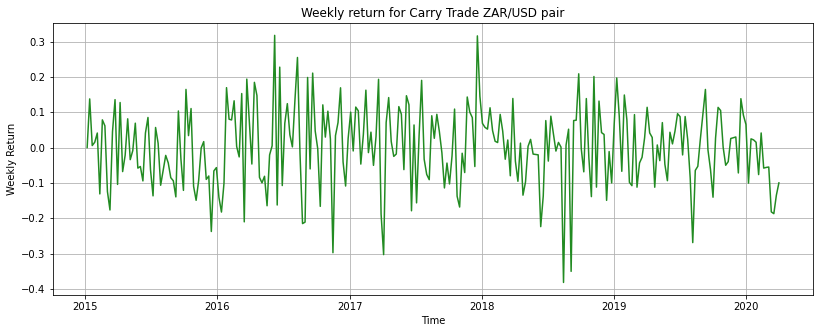

In [17]:
df=carry_trade("ZAR",perform="No",hist="No",weeklyreturn="Yes",cumulativepnl="No",fxmovement="No",yieldcurve="No",ratio="No",vix="No",graph=True)

<Figure size 1080x2520 with 0 Axes>

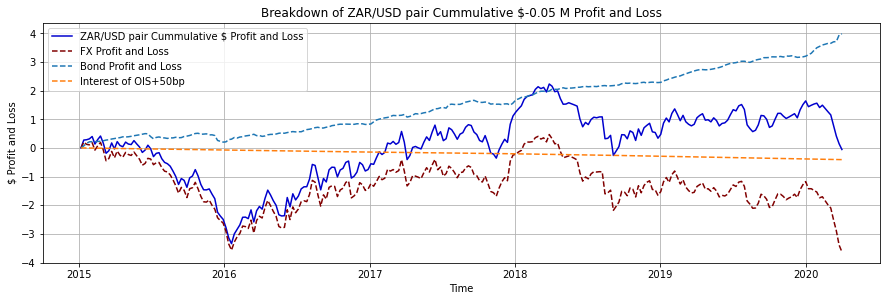

In [18]:
df=carry_trade("ZAR",perform="No",hist="No",weeklyreturn="No",cumulativepnl="Yes",fxmovement="No",yieldcurve="No",ratio="No",vix="No",graph=True)

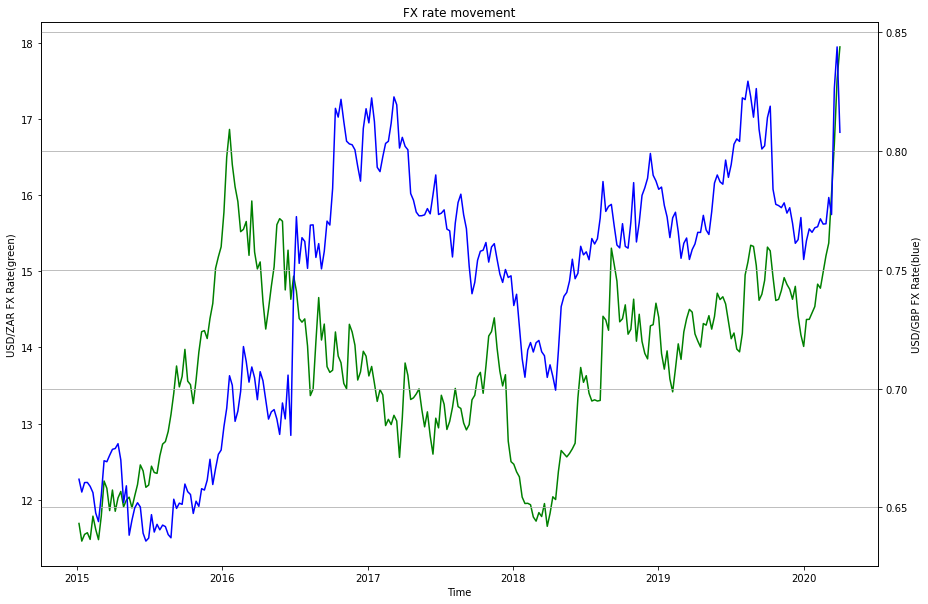

In [19]:
df=carry_trade("ZAR",perform="No",hist="No",weeklyreturn="No",cumulativepnl="No",fxmovement="Yes",yieldcurve="No",ratio="No",vix="No",graph=True)

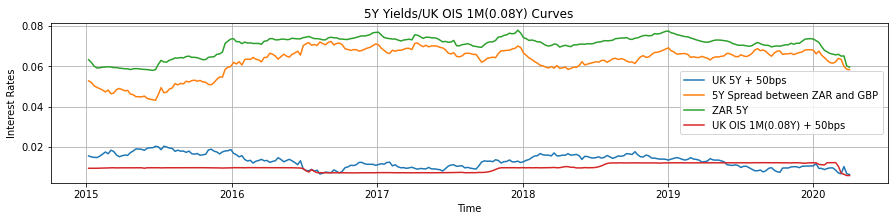

In [20]:
df=carry_trade("ZAR",perform="No",hist="No",weeklyreturn="No",cumulativepnl="No",fxmovement="No",yieldcurve="Yes",ratio="No",vix="No",graph=True)

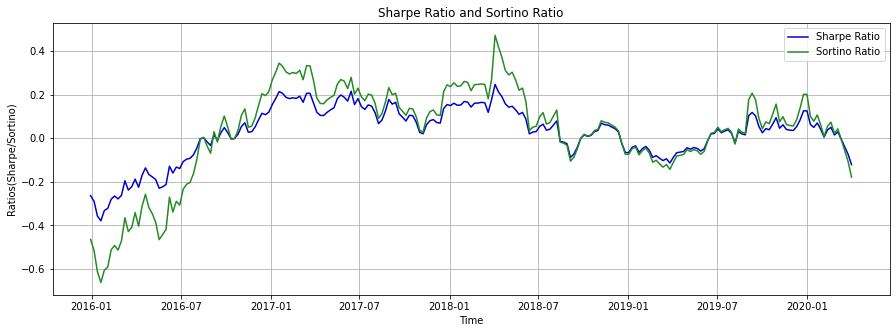

In [21]:
df=carry_trade("ZAR",perform="No",hist="No",weeklyreturn="No",cumulativepnl="No",fxmovement="No",yieldcurve="No",ratio="Yes",vix="No",graph=True)

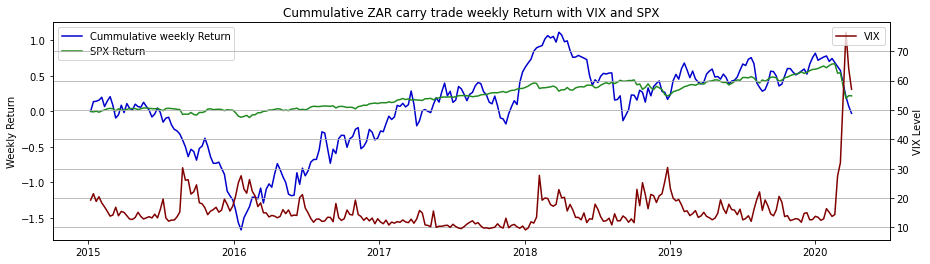

In [22]:
df=carry_trade("ZAR",perform="No",hist="No",weeklyreturn="No",cumulativepnl="No",fxmovement="No",yieldcurve="No",ratio="No",vix="Yes",graph=True)

# 4.2 THB Carry Trade(Thailand)

## 4.2.1 Return Analysis

**1.1 Return Distribution : We can see a high value of distribution around 0, the right tail is fatter than the one on the left, the median is >0 (more distribution to the right than left). Return Kurtosis is 7.93.**

* This appeara to be a great strategy with a mean weekly return of 0.0034 (0.1768 annualized), standard deviation of 0.0418 and Sharpe ratio of 0.081286.
* The distribution of returns is consistent with that of a carry trade strategy, with some fatness in the tails (excess kurtosis of 7.93) and some negative skewness (-0.20).

**1.2 Weekly Return: We can see when emerging market fx performed worst in 2015 August(RMB devaluated in August), 2016 January(when wti oil price drop to around 20 dollars a barrel), 2018(when Euro started to weaken from April and emerging market fx plummeting including Turkish Lira, India Rupee, Indonesia Rupiah) and 2020(when risk sentiment turned, emerging market risk asset plummeting). So the most important thing for carry trade is Emerging Market risk sentiment and some of the important indicators including Euro(US and non-US GDP growth difference), difference between interest rate market and risk sentiment for risk assets.**

* It is interesting to see the carry trade strategy's return which is driving not only from bond's profit but also in fx rate. Thai Baht carry trade strategy is special example.
* It started out losing money from 2015 with RMB devaluated to the end of 2016 with the passaway of its king "Bhumibol". And Thai Baht carry trade started to  enjoys a relatively long run of positive performance from 2017/1 to 2020/3, which is global recovery period. Because of Thailand's trade recovery of its export of eletronic products and Thailand's tourism recovery, Thai Baht started to strenghthen.
* It is very interesting to see that Thai Baht did not weakened as Euro and EM currencies. It is because of Thailand's strong current account surplus revival. However

**1.3 Cumulative Profit and Loss(Drivers of profit and loss): The total profit and loss is about 1,862,137. The profit from bond profit and loss is about 1,528,111. The profit from fx is about 709,623 and we also have to count borrowing cost for about 375,596.(Compared with other three carry trade, because thailand's 5y yield is relatively small, there will be some chance that we did not have carry trade position).** 

* As noted above, returns come primarily from two source: (i) changes in the value of the bond in the lend market resulting from changes in the yield curve there and (ii) foreign exchange movements.
* Profits result from decreases in rates in the lending market, driving up the price of the bond that we own.
* To be able to discern the impact on those effects separately, the components chart below shows the lend-borrow fx rate and the borrow-home fx rates separately.

*2015Q1-2016Q4*

* For the initial period of negative perfomance, negative peformance driven by significant unfavorable movements of THB fx rates.

*2017Q1-2019Q4*

* Relatively consistent positive perormance - exhibiting "normal" carry trade behavior - driven by, on average, declines in lend market yields and positive lend-borrw fx rate changes.

* This is actually quite a run, with nearly a 1.25x return on investment. If we were to look just at this period, this would look like a very attractive strategy.

*2020Q1*
* The THB fx exchange rate moved in the wrong direction - there were several days with nearly 4% unfavorable changes during the same time frame.
* The result is several single day drop of near 20% with a maximum drop of 22.7% on 2020-03-18.

In [23]:
df_thb, results_thb, tail_thb =carry_trade("THB",perform="Yes",tail="No",hist="No",weeklyreturn="No",cumulativepnl="No",fxmovement="No",yieldcurve="No",ratio="No",vix="No",graph=False)
results_thb

,Number of Weeks,Mean,Vol,Sharpe,Sortino,Min,Max,25% Quantile,75% Quantile,Skewness,Excess Kurtosis,VaR (Quantile 0.05)
Return,274,0.003398,0.041804,0.081286,0.098549,-0.227111,0.248764,-0.014961,0.024638,-0.202831,7.938371,-0.063777


In [24]:
df_thb, results_thb, tail_thb =carry_trade("THB",perform="No",tail="Yes",hist="No",weeklyreturn="No",cumulativepnl="No",fxmovement="No",yieldcurve="No",ratio="No",vix="No",graph=False)
tail_thb.T 

,Expected Shortfall,Expected Shortfall (Normal),Max Drawdown,MDD Start,MDD End,Recovery Date,Single Largest Drawdown,Single Largest Drawdown Date,Recovery period (days)
Return,-0.100143,-0.082831,-0.386174,2018-03-14,2018-10-31,2019-06-26,-0.227111,2020-03-18,469


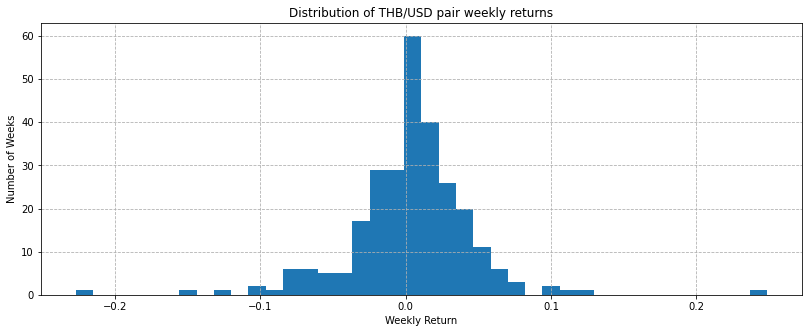

In [25]:
df=carry_trade("THB",perform="No",hist="Yes",weeklyreturn="No",cumulativepnl="No",fxmovement="No",yieldcurve="No",ratio="No",vix="No",graph=True)

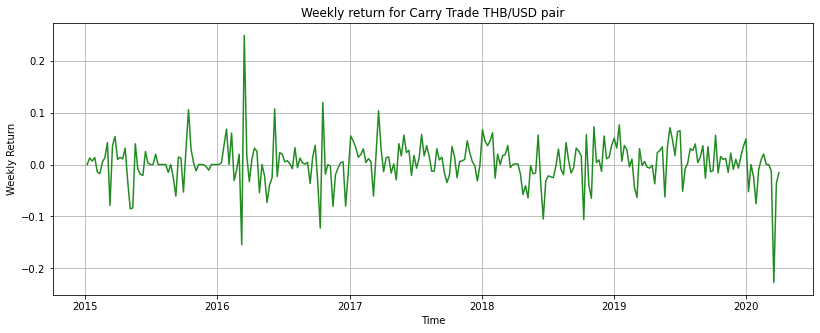

In [26]:
df=carry_trade("THB",perform="No",hist="No",weeklyreturn="Yes",cumulativepnl="No",fxmovement="No",yieldcurve="No",ratio="No",vix="No",graph=True)

<Figure size 1080x2520 with 0 Axes>

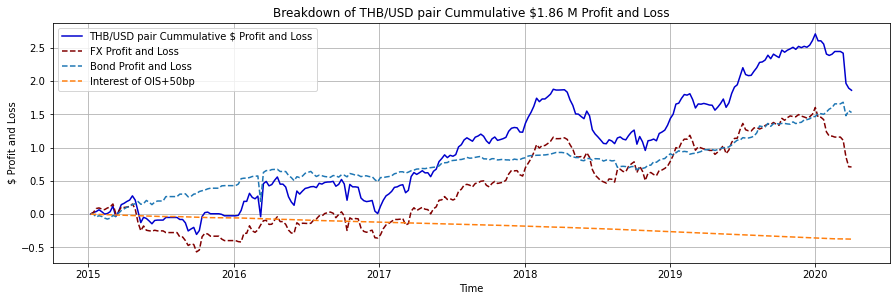

In [27]:
df=carry_trade("THB",perform="No",hist="No",weeklyreturn="No",cumulativepnl="Yes",fxmovement="No",yieldcurve="No",ratio="No",vix="No",graph=True)

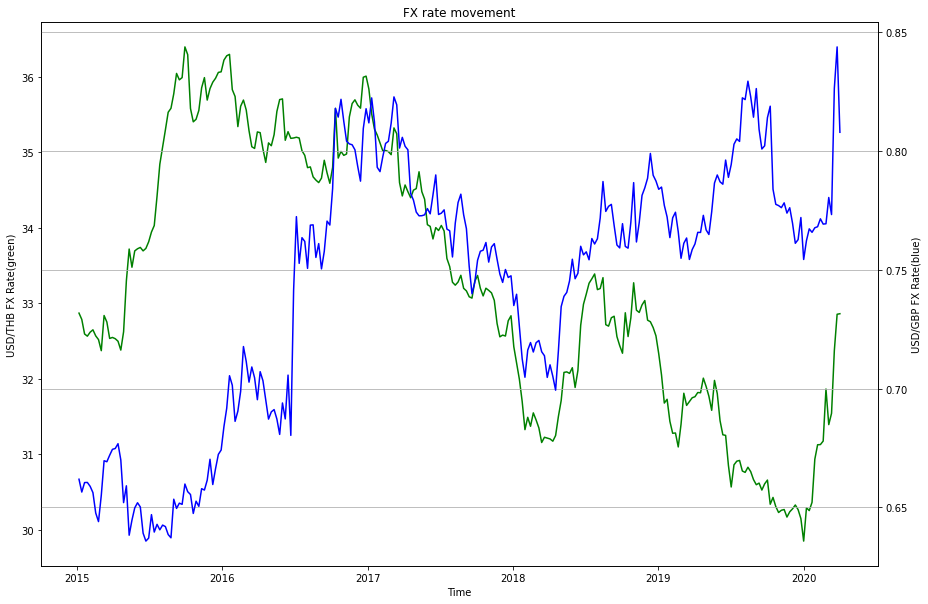

In [28]:
df=carry_trade("THB",perform="No",hist="No",weeklyreturn="No",cumulativepnl="No",fxmovement="Yes",yieldcurve="No",ratio="No",vix="No",graph=True)

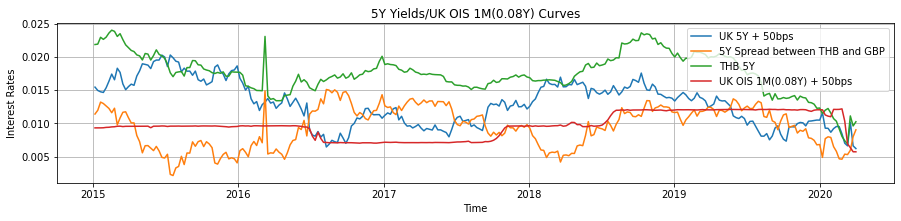

In [29]:
df=carry_trade("THB",perform="No",hist="No",weeklyreturn="No",cumulativepnl="No",fxmovement="No",yieldcurve="Yes",ratio="No",vix="No",graph=True)

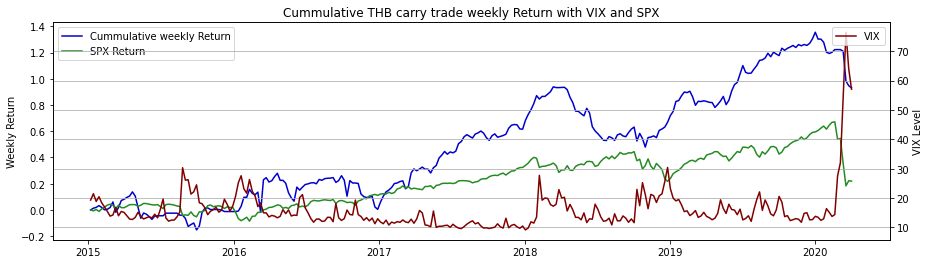

In [30]:
df=carry_trade("THB",perform="No",hist="No",weeklyreturn="No",cumulativepnl="No",fxmovement="No",yieldcurve="No",ratio="No",vix="Yes",graph=True)

# 4.3 PKR Carry Trade(Pakistan)

## 4.3.1 Return Analysis

**1.1 Return Distribution : We can see a high value of distribution around 0, the left tail is fatter than the one on the right, the median is <0 (a little more distribution to the left than right). Return Kurtosis is 13.06.**

* This doesn't appear to be a great strategy with a mean weekly return of -0.0015 (-0.078 annualized), standard deviation of 0.064699 and Sharpe ratio of -0.023153.
* The distribution of returns is consistent with that of a carry trade strategy, with some fatness in the tails (excess kurtosis of 13.068) and some negative skewness (-2.1278).

**1.2 Weekly Return: We can see that before 2017/12 Pakistan Rupee(USD/PKR) is fairly stable around 105. After Pakistan government held talks with the IMF, Pakistan agreed to depreciate the rupee.There was a significant adjustment in the currency.(USD/PKR moved from 105 to 154.5 since 2017)**

* It started out losing money from 2018 when Pakistan started to devaluate Pakistan Rupee(USD/PKR).

**1.3 Cumulative Profit and Loss(Drivers of profit and loss): The total profit and loss is about -820,885. The profit from bond profit and loss is about 4,358,067. The loss from fx is about 4,771,212 and we also have to count borrowing cost for about 320,092.** 

* As noted above, returns come primarily from two source: (i) changes in the value of the bond in the lend market resulting from changes in the yield curve there and (ii) foreign exchange movements.
* Profits result from decreases in rates in the lending market, driving up the price of the bond that we own.
* To be able to discern the impact on those effects separately, the components chart below shows the lend-borrow fx rate and the borrow-home fx rates separately.

*2015Q1-2017Q4*

* Relatively consistent positive perormance - exhibiting "normal" carry trade behavior - driven by, on average, declines in lend market yields.

* This is actually quite a run, with nearly a 1.27x return on investment. If we were to look just at this period, this would look like a very attractive strategy.

*2018Q1-2020Q1*

* The PKR fx exchange rate moved in the wrong direction.

In [31]:
df_pkr, results_pkr, tail_pkr =carry_trade("PKR",perform="Yes",tail="No",hist="No",weeklyreturn="No",cumulativepnl="No",fxmovement="No",yieldcurve="No",ratio="No",vix="No",graph=False)
results_pkr

,Number of Weeks,Mean,Vol,Sharpe,Sortino,Min,Max,25% Quantile,75% Quantile,Skewness,Excess Kurtosis,VaR (Quantile 0.05)
Return,274,-0.001498,0.064699,-0.023153,-0.019702,-0.431908,0.261881,-0.009113,0.020257,-2.127870,13.068438,-0.110192


In [32]:
df_pkr, results_pkr, tail_pkr =carry_trade("PKR",perform="No",tail="Yes",hist="No",weeklyreturn="No",cumulativepnl="No",fxmovement="No",yieldcurve="No",ratio="No",vix="No",graph=False)
tail_pkr.T 

,Expected Shortfall,Expected Shortfall (Normal),Max Drawdown,MDD Start,MDD End,Recovery Date,Single Largest Drawdown,Single Largest Drawdown Date,Recovery period (days)
Return,-0.208395,-0.134953,-0.955402,2017-11-15,2019-08-21,None,-0.431908,2019-05-22,NaN


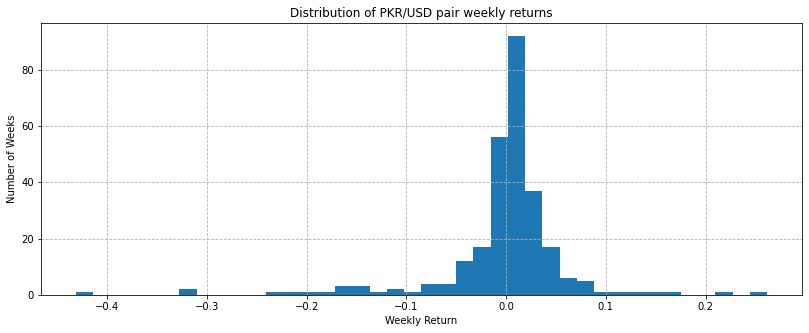

In [33]:
df=carry_trade("PKR",perform="No",hist="Yes",weeklyreturn="No",cumulativepnl="No",fxmovement="No",yieldcurve="No",ratio="No",vix="No",graph=True)

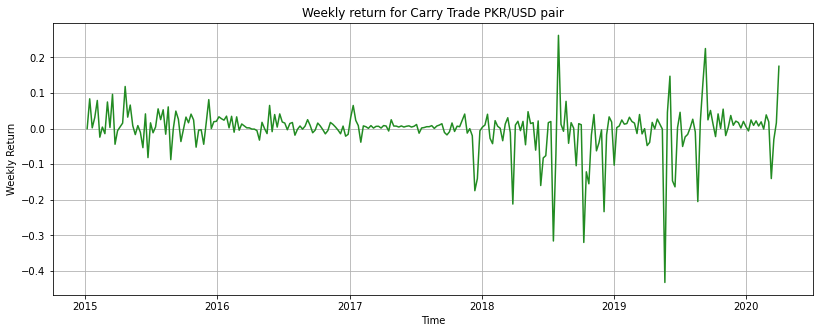

In [34]:
df=carry_trade("PKR",perform="No",hist="No",weeklyreturn="Yes",cumulativepnl="No",fxmovement="No",yieldcurve="No",ratio="No",vix="No",graph=True)

<Figure size 1080x2520 with 0 Axes>

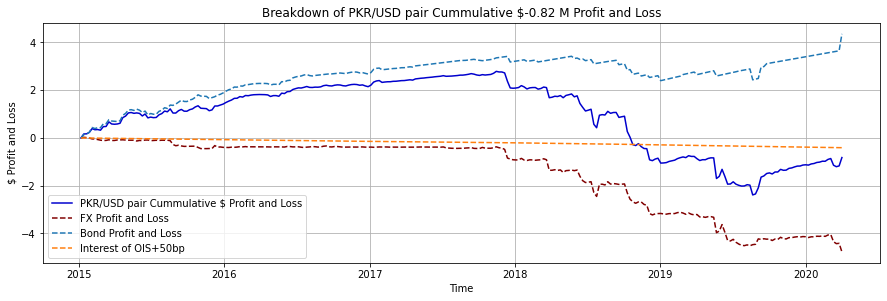

In [35]:
df=carry_trade("PKR",perform="No",hist="No",weeklyreturn="No",cumulativepnl="Yes",fxmovement="No",yieldcurve="No",ratio="No",vix="No",graph=True)

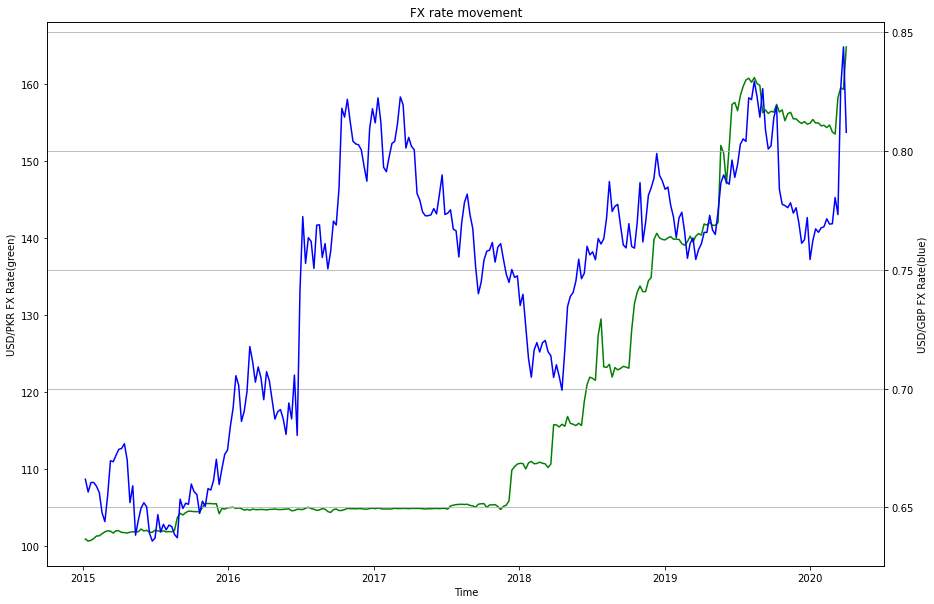

In [36]:
df=carry_trade("PKR",perform="No",hist="No",weeklyreturn="No",cumulativepnl="No",fxmovement="Yes",yieldcurve="No",ratio="No",vix="No",graph=True)

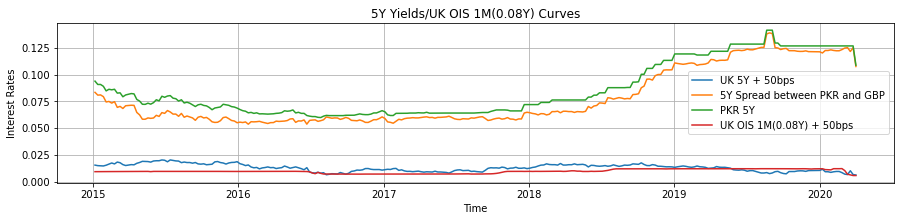

In [37]:
df=carry_trade("PKR",perform="No",hist="No",weeklyreturn="No",cumulativepnl="No",fxmovement="No",yieldcurve="Yes",ratio="No",vix="No",graph=True)

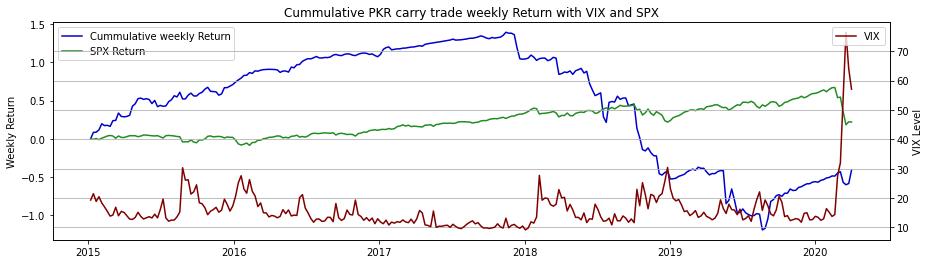

In [38]:
df=carry_trade("PKR",perform="No",hist="No",weeklyreturn="No",cumulativepnl="No",fxmovement="No",yieldcurve="No",ratio="No",vix="Yes",graph=True)

# 4.4 PHP Carry Trade(Philippines)

## 4.4.1 Return Analysis

**1.1 Return Distribution : We can see a high value of distribution around 0, the right tail is fatter than the one on the left, the median is >0 (more distribution to the right than left). Return Kurtosis is 10.64.**

* This appeara to be a great strategy with a mean weekly return of 0.005074 (0.2638 annualized), standard deviation of 0.0515 and Sharpe ratio of 0.098462.
* The distribution of returns is consistent with that of a carry trade strategy, with some fatness in the tails (excess kurtosis of 10.6425) and some postive skewness (0.90).

**1.2 Weekly Return: We can see when emerging market fx performed worst in 2015 August(RMB devaluated in August), 2016 to 2019 other than global risk sentiment turned, Philippines Peso started to depreciate because newly elected president started to increase imports for infrastructure. So the most important thing for carry trade other than Emerging Market risk sentiment is the performance of its currency.**

* The profit which came from bond greatly covered the loss from currency from 2015 to 2017. However when the philippine 5y yield interest started to rise, we can see the profit and loss suffered from both bond and fx. When the Philippines 5y yield and peso started to stabilize in 2019, the profit started to recover.

**1.3 Cumulative Profit and Loss(Drivers of profit and loss): The total profit and loss is about 2,780,631. The profit from bond profit and loss is about 4,358,067. The loss from fx is about 1,169,695 and we also have to count borrowing cost for about 407,740.** 

* As noted above, returns come primarily from two source: (i) changes in the value of the bond in the lend market resulting from changes in the yield curve there and (ii) foreign exchange movements.
* Profits result from decreases in rates in the lending market, driving up the price of the bond that we own.
* To be able to discern the impact on those effects separately, the components chart below shows the lend-borrow fx rate and the borrow-home fx rates separately.

*2015Q1-2017Q4*

* For the initial period of positive perfomance, positive peformance driven by declines in lend market yields which covered the loss by fx.


*2018Q1-2018Q4*

* Relatively negative perormance was driven by increases in lend market yields and negative lend-borrww fx rate changes. However, we could see that lend fx rate started to rebound.

*2019Q1-2020Q1*

* Relatively consistent positive perormance - exhibiting "normal" carry trade behavior - driven by, on average, declines in lend market yields and positive lend-borrw fx rate changes.

* This is actually quite a run, with nearly a 1.25x return on investment. If we were to look just at this period, this would look like a very attractive strategy.

In [39]:
df_php, results_php, tail_php =carry_trade("PHP",perform="Yes",tail="No",hist="No",weeklyreturn="No",cumulativepnl="No",fxmovement="No",yieldcurve="No",ratio="No",vix="No",graph=False)
results_php

,Number of Weeks,Mean,Vol,Sharpe,Sortino,Min,Max,25% Quantile,75% Quantile,Skewness,Excess Kurtosis,VaR (Quantile 0.05)
Return,274,0.005074,0.051534,0.098462,0.141539,-0.237930,0.358851,-0.016924,0.032226,0.901011,10.642526,-0.077047


In [40]:
df_php, results_php, tail_php=carry_trade("PHP",perform="No",tail="Yes",hist="No",weeklyreturn="No",cumulativepnl="No",fxmovement="No",yieldcurve="No",ratio="No",vix="No",graph=False)
tail_php.T 

,Expected Shortfall,Expected Shortfall (Normal),Max Drawdown,MDD Start,MDD End,Recovery Date,Single Largest Drawdown,Single Largest Drawdown Date,Recovery period (days)
Return,-0.109472,-0.101226,-0.617785,2016-08-17,2019-08-21,2020-04-01,-0.237930,2019-08-21,1323


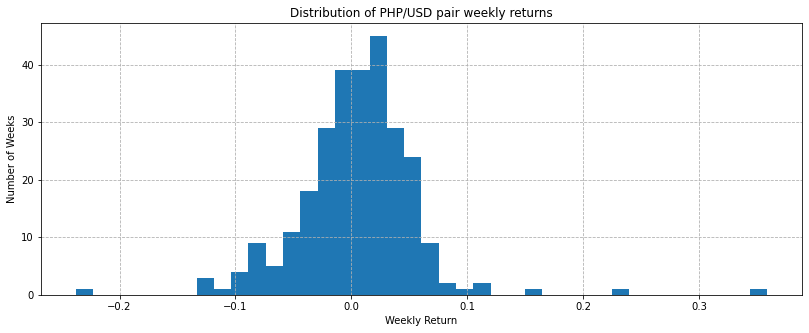

In [41]:
df=carry_trade("PHP",perform="No",hist="Yes",weeklyreturn="No",cumulativepnl="No",fxmovement="No",yieldcurve="No",ratio="No",vix="No",graph=True)

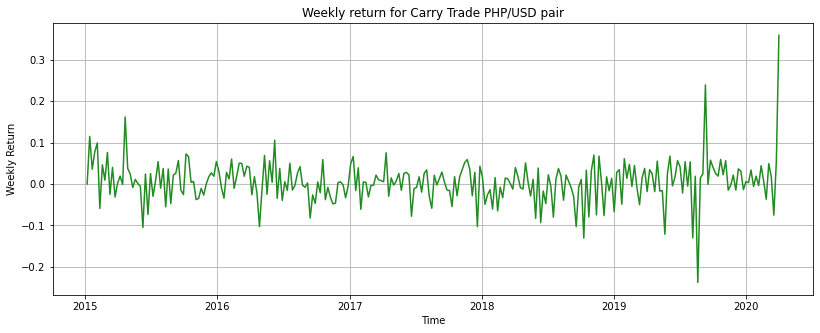

In [42]:
df=carry_trade("PHP",perform="No",hist="No",weeklyreturn="Yes",cumulativepnl="No",fxmovement="No",yieldcurve="No",ratio="No",vix="No",graph=True)

<Figure size 1080x2520 with 0 Axes>

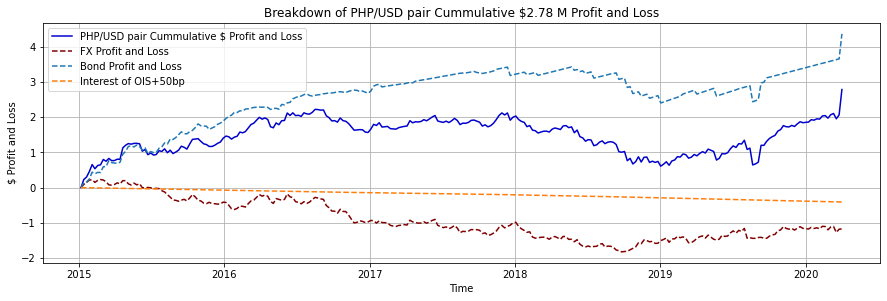

In [43]:
df=carry_trade("PHP",perform="No",hist="No",weeklyreturn="No",cumulativepnl="Yes",fxmovement="No",yieldcurve="No",ratio="No",vix="No",graph=True)

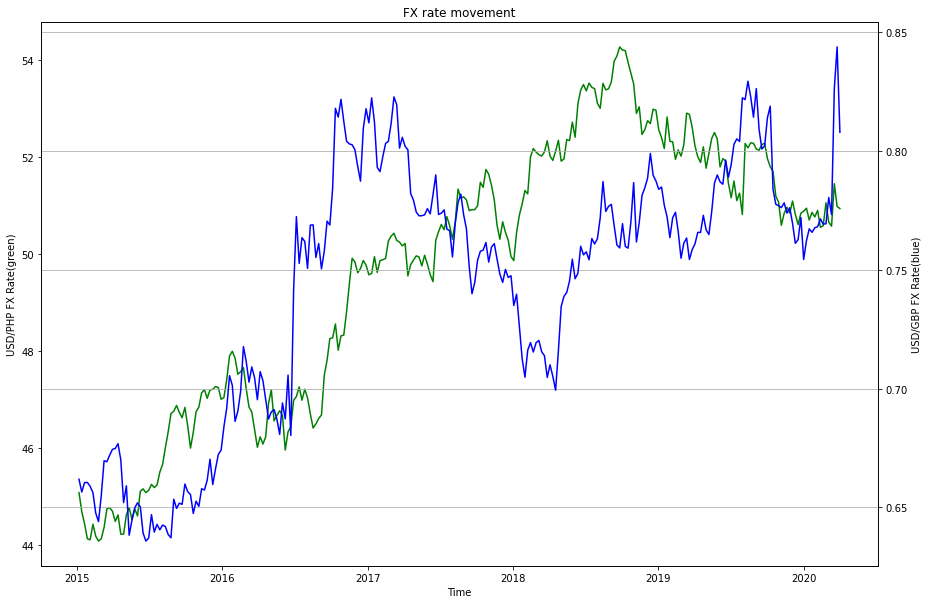

In [44]:
df=carry_trade("PHP",perform="No",hist="No",weeklyreturn="No",cumulativepnl="No",fxmovement="Yes",yieldcurve="No",ratio="No",vix="No",graph=True)

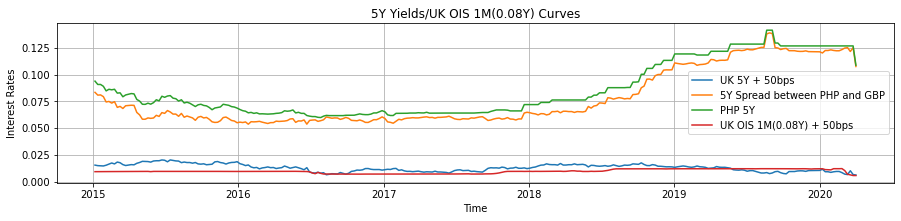

In [45]:
df=carry_trade("PHP",perform="No",hist="No",weeklyreturn="No",cumulativepnl="No",fxmovement="No",yieldcurve="Yes",ratio="No",vix="No",graph=True)

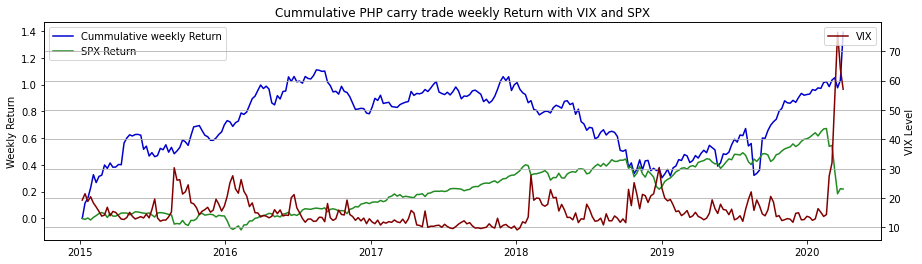

In [46]:
df=carry_trade("PHP",perform="No",hist="No",weeklyreturn="No",cumulativepnl="No",fxmovement="No",yieldcurve="No",ratio="No",vix="Yes",graph=True)

# 5. Conclusion 

* The carry trade trading strategies that involves the Philippine Peso and Thai Bhat were the best, producing a cumulative return of 2.78 million USD and 1.86 million USD over the period with a Sharpe ratio of just 0.098462 and 0.081826.
* Profit was negatively impacted in most of the strategies by unfavorable fx rate movements except for Thai Baht. FX rates is one of the dominant factor in the overall PNL, especially given than the currencies we are lending in are Emerging Market there is greater FX risk. 
* The Lending Bond PNL generally is significant, until we see FX move against us and wipe it out. Thus one of the crucial element is market timing for fx downside risk. Sudden movements in FX also impact the Bond PNL significantly.
* This was a relativlely long investment horizon and there were periods of several years where the strategies produced relatively consisent positive returns. If there were a way to prevent the extreme losses, perhaps putting in place stop loss limits that were evaluated on a more frequent basis than weekly, the performance could be acceptable for some periods of time.